In [1]:
from collections import defaultdict

import gseapy as gp
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats

import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import leaves_list, linkage
from scipy.spatial.distance import pdist, squareform

from scripts import aesthetics
from scripts import manuscript_colors as mc

aesthetics.activate_paper_rcParams('illustrator')

In [2]:
import palettable

Bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

# GSEA analysis

In this notebook, we analyze the results from `cwas-gene-set-enrichment` and make associated figures.

# Read in data

## Category SVs

In [3]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/updated-cwas/svs-in-categories/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t")
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding


## Framework results

In [4]:
#########################
### FRAMEWORK RESULTS ###
#########################
columns = ['category_name', 'point_estimate', 'std_error', 'z_score', 'p_value']
framework_results = []
for file in glob.glob("data/updated-cwas/summary-stats/*.txt"):

    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t", usecols = columns)
    data[["disease", "sv_category"]] = [
        disease,
        sv_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)
framework_results['negative_log10_p_value'] = -np.log10(framework_results['p_value'])

In [5]:
num_tests = {
    "neuroblastoma-coding": 321,
    "neuroblastoma-noncoding": 940,
    "ewing-coding": 322,
    "ewing-noncoding": 918,
}

bonf_nlp_thresholds = {d: -np.log10(0.05 / n_test) for d, n_test in num_tests.items()}

framework_results["bonferroni_p"] = framework_results.apply(
    lambda row: row["p_value"] * num_tests[row["disease"] + "-" + row["sv_category"]],
    axis=1,
)

framework_results["bonferroni_significant"] = framework_results["bonferroni_p"] < 0.05

In [6]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/updated-cwas/schema/*.txt"):

    sv_category = "noncoding" if "noncoding" in file else "coding"
    suffix = file.split("/")[-1]
    if sv_category == "coding":
        disease = suffix.split('_')[2]
    else:
        disease = suffix.split('_')[3]

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

## GSEA results

In [7]:
ref_counts = pd.read_csv("data/cwas-results/reference-counts.csv")

In [25]:
gse_results = pd.read_csv("data/updated-cwas/results/cwas-gene-set-enrichment-results.csv")

# subset data
gse_results = gse_results[
    gse_results["category"].isin(framework_results["category_name"].tolist())
]

In [26]:
gse_results.head(2)

,disease,category,sv_category,gs,ref_freq_cases,cat_freq_cases,num_unique_genes_in_overlap_cases,odds_ratio_cases,p_cases,fdr_p_cases,bonf_p_cases,ref_freq_controls,cat_freq_controls,num_unique_genes_in_overlap_controls,odds_ratio_controls,p_controls,fdr_p_controls,bonf_p_controls
0,ewing,ANY.SINGLETON.PREDICTED_COPY_GAIN.lof_constrai...,coding,regulation of protein secretion (GO:0050708),54/3909,1/50,1,2.804364,0.505341,1.0,1377.053474,270/22714,0/192,0,0.429134,0.179149,0.513875,488.181684
1,ewing,ANY.SINGLETON.PREDICTED_COPY_GAIN.lof_constrai...,coding,negative regulation of fibroblast proliferatio...,3/3909,0/50,0,19.151961,1.000000,1.0,2725.000000,7/22714,1/192,1,29.567708,0.065132,0.288123,177.483892


In [27]:
export = gse_results[['disease', 'category', 'sv_category', 'gs', 
             'ref_freq_cases', 'cat_freq_cases', 'num_unique_genes_in_overlap_cases', 'odds_ratio_cases', 'p_cases', 'bonf_p_cases',
             'ref_freq_controls', 'cat_freq_controls', 'num_unique_genes_in_overlap_controls', 'odds_ratio_controls', 'p_controls', 'bonf_p_controls',
            ]].copy()

## Gene sets

In [28]:
gene_sets = {}
with open("data/updated-cwas/go-gene-sets.txt") as gs_in:
    for line in gs_in:
        comp = line.strip().split("\t")
        gs = comp[0]
        genes = comp[1:]

        if len(genes) >= 30 and len(genes) <= 1000:
            gene_sets[gs] = genes

Establish bonferroni cutoff.

In [29]:
num_gene_sets = 2725
p_bonf_cutoff = 0.05 / 2725

Add size of gene set to dataframe

In [30]:
gs_size = export['gs'].apply(lambda gs: len(gene_sets[gs]))
export.insert(4, 'size_of_gene_set', gs_size)

In [35]:
for col in export.columns:
    if 'bonf' in col:
        export[col] = np.where(export[col] > 1, 1, export[col])

In [37]:
export.to_csv('data/gsea-supplementary-table.tsv', index = False, sep = '\t')

In [38]:
!open data

# Plot gene set results

We do this for a particular category (all singletons)

In [12]:
# bonferroni_cats = framework_results.query(
#     'sv_category == "coding" & bonferroni_significant == True'
# )
# bonferroni_cats["category_name"].value_counts()

So a few categories are present in both. I think it makes the most sense to show the top level category, since that's very interesting in terms of baseline findings.

In [13]:
labeled_gs = ['central nervous system development (GO:0007417)', 'positive regulation of synaptic transmission (GO:0050806)',
              'calcium ion homeostasis (GO:0055074)', 'peptide biosynthetic process (GO:0043043)']

In [15]:
gse_results

,disease,category,sv_category,gs,ref_freq_cases,cat_freq_cases,num_unique_genes_in_overlap_cases,odds_ratio_cases,p_cases,fdr_p_cases,bonf_p_cases,ref_freq_controls,cat_freq_controls,num_unique_genes_in_overlap_controls,odds_ratio_controls,p_controls,fdr_p_controls,bonf_p_controls
0,ewing,ANY.SINGLETON.PREDICTED_COPY_GAIN.lof_constrai...,coding,regulation of protein secretion (GO:0050708),54/3909,1/50,1,2.804364,0.505341,1.000000,1377.053474,270/22714,0/192,0,0.429134,1.791492e-01,0.513875,488.181684
1,ewing,ANY.SINGLETON.PREDICTED_COPY_GAIN.lof_constrai...,coding,negative regulation of fibroblast proliferatio...,3/3909,0/50,0,19.151961,1.000000,1.000000,2725.000000,7/22714,1/192,1,29.567708,6.513170e-02,0.288123,177.483892
2,ewing,ANY.SINGLETON.PREDICTED_COPY_GAIN.lof_constrai...,coding,neuron apoptotic process (GO:0051402),5/3909,0/50,0,12.761438,1.000000,1.000000,2725.000000,41/22714,4/192,4,14.281935,5.448723e-04,0.020339,1.484777
3,ewing,ANY.SINGLETON.PREDICTED_COPY_GAIN.lof_constrai...,coding,regulation of peptide hormone secretion (GO:00...,22/3909,0/50,0,3.314578,1.000000,1.000000,2725.000000,165/22714,0/192,0,0.703852,6.514381e-01,1.000000,1775.168690
4,ewing,ANY.SINGLETON.PREDICTED_COPY_GAIN.lof_constrai...,coding,positive regulation of mitotic cell cycle phas...,14/3909,1/50,1,10.389333,0.173858,1.000000,473.762350,54/22714,2/192,2,6.471490,8.021575e-02,0.324317,218.587927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207245,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neurobl...,noncoding,establishment of mitotic spindle orientation (...,324/113720,0/68,0,5.056722,1.000000,1.000000,2724.999999,2556/894520,0/353,0,0.985403,6.315391e-01,1.000000,1720.944015
2207246,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neurobl...,noncoding,nucleoside metabolic process (GO:0009116),311/113720,4/68,1,27.961045,0.000041,0.111197,0.111197,2326/894520,15/353,1,18.096046,5.349004e-07,0.000729,0.001458
2207247,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neurobl...,noncoding,regulation of cell fate commitment (GO:0010453),250/113720,0/68,0,6.551822,1.000000,1.000000,2725.000000,1758/894520,0/353,0,1.433729,1.000000e+00,1.000000,2724.999996
2207248,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neurobl...,noncoding,regulation of developmental growth (GO:0048638),3070/113720,2/68,2,1.613325,0.706581,1.000000,1925.433561,24776/894520,13/353,10,1.441176,3.261028e-01,1.000000,888.629994


[Text(0, 0, '1'), Text(2, 0, '4'), Text(4, 0, '16'), Text(6, 0, '64')]

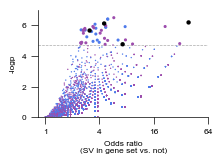

In [14]:
test_cat = "ANY.SINGLETON.ANY.ANY.ANY.protein_coding"

palette = {'neuroblastoma': mc.palette['neuroblastoma']["main"],
           'ewing': mc.palette['ewing']["main"]}

fig, ax = plt.subplots(1, figsize=(2.2, 1.4))

# data = combined_gse_results.query('odds_ratio_cases_fisher > odds_ratio_controls_fisher').copy()
coding_results = gse_results.query('sv_category == "coding" & odds_ratio_cases > 1').copy()
coding_results["x_baseline"] = np.log2(coding_results["odds_ratio_cases"])
coding_results["y_baseline"] = -np.log10(coding_results["p_cases"])

data = coding_results.query(f'category == "{test_cat}"').copy()

nlp_bonf = -np.log10(p_bonf_cutoff)
data['size'] = np.where(data['y_baseline'] > nlp_bonf, 5, 1)
data['c'] = data['disease'].replace(palette)

# plot the significant ones first
sig = data.query(f'y_baseline > {nlp_bonf}')
points = ax.scatter(x = sig['x_baseline'], y = sig['y_baseline'], s = sig['size'], ec = None, c = sig['c'])

labeled_sig = sig[sig['gs'].isin(labeled_gs)]
points = ax.scatter(x = labeled_sig['x_baseline'], y = labeled_sig['y_baseline'], s = 10, ec = None, c = 'black')

nonsig = data.query(f'y_baseline < {nlp_bonf}').sample(frac = 1)
for chunk in np.array_split(nonsig, 200):
    zorder = np.random.uniform()
    points = ax.scatter(x = chunk['x_baseline'], y = chunk['y_baseline'], s = chunk['size'], ec = None, c = chunk['c'])

sns.despine(ax=ax)
ax.set_xlim([None, 6])
ax.set_ylim([0, 7])
ax.axhline(
    y=nlp_bonf,
    linestyle="dashed",
    color="darkgrey",
    zorder=-1,
    linewidth = 0.5
)
ax.set_ylabel("-logp")
ax.set_xlabel("Odds ratio\n(SV in gene set vs. not)", fontsize = 6)

ax.set_xticks([0, 2, 4, 6])
ax.set_xticklabels([1, 4, 16, 64])

# fig.savefig('data/updated-cwas/images/singleton-sv-gene-sets-fig4b.pdf')

In [16]:
sig[lambda row: row['gs'].isin(labeled_gs)][['disease', 'gs', 'odds_ratio_cases', 'p_cases', 'odds_ratio_controls', 'p_controls']]

,disease,gs,odds_ratio_cases,p_cases,odds_ratio_controls,p_controls
13890,ewing,calcium ion homeostasis (GO:0055074),7.221053,1.760529e-05,2.509681,0.000002
15485,ewing,peptide biosynthetic process (GO:0043043),4.513246,7.867191e-07,2.285493,0.000003
930123,neuroblastoma,positive regulation of synaptic transmission (...,38.700980,6.734507e-07,5.896425,0.000028
931065,neuroblastoma,central nervous system development (GO:0007417),3.115939,2.255479e-06,1.697055,0.000005


# Try to visualize some case-control odds ratios

So we've shown that the odd's ratios are up in cases - we have the comparison in controls.

There are a few category-gene set pairs that I'd like to highlight. We also have some that Riaz highlighted for us.

In [24]:
category_geneset_pairs = [['neuroblastoma', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['ewing', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'calcium ion homeostasis (GO:0055074)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'calcium ion homeostasis (GO:0055074)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 'calcium ion homeostasis (GO:0055074)'],
                          ['ewing', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'peptide biosynthetic process (GO:0043043)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'peptide biosynthetic process (GO:0043043)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 'peptide biosynthetic process (GO:0043043)'],
                          # ['neuroblastoma', 'ANY.RARE.ANY.ANY.ANY.protein_coding', 'heterochromatin organization (GO:0070828)'],
                          # ['neuroblastoma', 'DEL.RARE.ANY.ANY.ANY.protein_coding', 'heterochromatin organization (GO:0070828)'],
                          # ['neuroblastoma', 'DEL.RARE.ANY.lof_constrained.ANY.protein_coding', 'heterochromatin organization (GO:0070828)']
                         ]

category_geneset_pairs = np.array(category_geneset_pairs)

We also add a calculation for the odds ratio confidence intervals.

In [25]:
import statsmodels.api as sm

In [26]:
def calculate_or_ci(row):
    
    results = []
    for cohort in ['cases', 'controls']:
        top_row = np.array(row[f'cat_freq_{cohort}'].split('/')).astype(int)
        bottom_row = np.array(row[f'ref_freq_{cohort}'].split('/')).astype(int)
        
        # adjust to actual counts
        top_row[1] = top_row[1] - top_row[0]
        bottom_row[1] = bottom_row[1] - bottom_row[0]
        
        table = np.array([top_row, bottom_row]).astype(int) + 1
        
        table = sm.stats.Table2x2(table)
        
        odds = table.log_oddsratio
        ci = table.log_oddsratio_confint()
        
        results += [odds] + list(ci)
        
    return results

In [27]:
plot_results = []
log_odds_ratio_intervals = []
for dz, cat, gs in category_geneset_pairs:
    res = gse_results[lambda row: (row['disease'] == dz) & 
                               (row['category'] == cat) & 
                               (row['gs'] == gs) & 
                               (row['sv_category'] == "coding")]

    assert len(res) == 1
    
    log_odds_ratios = calculate_or_ci(res.iloc[0])
    log_odds_ratio_intervals.append(log_odds_ratios)
    
    plot_results.append(res)
    
plot_results = pd.concat(plot_results).reset_index()

# convert from ln to log2
log_odds_ratio_intervals = log_odds_ratio_intervals / np.log(2)

plot_results[['cases_logor', 'cases_logor_upper', 'cases_logor_lower', 'controls_logor', 
              'controls_logor_upper', 'controls_logor_lower']] = log_odds_ratio_intervals

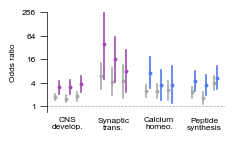

In [29]:
fig, ax = plt.subplots(1, figsize = (2.3, 1.3)) 
                         # gridspec_kw = {'hspace': 0.1, 'height_ratios': [1, 0.2]}, sharex = True)

x = 0
xticks = []
for index, row in plot_results.iterrows():
    dz = row['disease']
    
    for cohort in ['controls', 'cases']:
        
        color = palette[dz] if cohort == "cases" else "darkgrey"
        
        y_val = row[f'{cohort}_logor']
        y_upper = row[f'{cohort}_logor_upper']
        y_lower = row[f'{cohort}_logor_lower']
        ax.scatter([x], [y_val], s = 4, color = color)
        ax.plot([x, x], [y_upper, y_lower], color = color)
    
        if cohort == 'controls':
            xticks.append(x + 0.4)

        x += 0.8

    x += 1
    
    if (index + 1) % 3 == 0:
        x += 3
        
ax.set_yticks([-2, 0, 2, 4, 6, 8])
ax.set_yticklabels([0.25, 1, 4, 16, 64, 256])
ax.set_ylim([-0.5, 8])
ax.axhline(y = 0, color = 'darkgrey', linestyle = 'dashed', zorder = -1, linewidth = 0.5)
aesthetics.strip_axis(ax, x = 'label', y = 'ignore')
ax.set_ylabel('Odds ratio')
ax.set_xticks(xticks[1::3])
ax.set_xticklabels(['CNS\ndevelop.', 'Synaptic\ntrans.', 'Calcium\nhomeo.', 'Peptide\nsynthesis'], fontsize = 6)

fig.savefig('data/updated-cwas/images/gsea-odds-ratios-line-plot.pdf', bbox_inches = 'tight')

In [66]:
2**3.1159

8.669206810306202

In [65]:
plot_results

,index,disease,category,sv_category,gs,ref_freq_cases,cat_freq_cases,num_unique_genes_in_overlap_cases,odds_ratio_cases,p_cases,...,odds_ratio_controls,p_controls,fdr_p_controls,bonf_p_controls,cases_logor,cases_logor_upper,cases_logor_lower,controls_logor,controls_logor_upper,controls_logor_lower
0,931065,neuroblastoma,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,coding,central nervous system development (GO:0007417),63/3157,49/824,44,3.115939,2.255479e-06,...,1.697055,0.000005,0.000029,0.012894,1.639667,1.094024,2.185310,0.763033,0.507615,1.018452
1,876565,neuroblastoma,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,coding,central nervous system development (GO:0007417),75/3411,37/570,32,3.124532,1.384060e-06,...,1.565650,0.000083,0.000692,0.226233,1.643640,1.066595,2.220685,0.646762,0.345844,0.947680
2,873840,neuroblastoma,DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,coding,central nervous system development (GO:0007417),90/3714,22/267,18,3.724426,3.157001e-06,...,1.804483,0.000123,0.001013,0.336397,1.897018,1.211307,2.582730,0.851586,0.458041,1.245131
3,930123,neuroblastoma,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,coding,positive regulation of synaptic transmission (...,0/3157,9/824,9,38.700980,6.734507e-07,...,5.896425,0.000028,0.000125,0.075771,5.274298,2.306576,8.242020,2.559841,1.446479,3.673202
4,875623,neuroblastoma,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,coding,positive regulation of synaptic transmission (...,2/3411,7/570,7,16.122931,3.302801e-05,...,4.286446,0.003101,0.011884,8.449820,4.011042,2.092417,5.929667,2.099782,0.932829,3.266734
5,872898,neuroblastoma,DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,coding,positive regulation of synaptic transmission (...,6/3714,3/267,3,7.997844,1.850863e-02,...,4.440230,0.031585,0.081737,86.068886,2.999611,1.218203,4.781019,2.150635,0.741362,3.559907
6,13890,ewing,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,coding,calcium ion homeostasis (GO:0055074),6/3092,13/867,12,7.221053,1.760529e-05,...,2.509681,0.000002,0.000020,0.006010,2.852209,1.538717,4.165701,1.327504,0.817774,1.837234
7,30240,ewing,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,coding,calcium ion homeostasis (GO:0055074),12/3364,7/595,7,3.503200,1.625753e-02,...,2.468931,0.000043,0.000427,0.117543,1.808673,0.531789,3.085558,1.303886,0.740949,1.866824
8,27515,ewing,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skel...,coding,calcium ion homeostasis (GO:0055074),16/3717,3/242,3,3.629412,1.060402e-01,...,2.596252,0.007673,0.034225,20.907849,1.859736,0.277121,3.442351,1.376430,0.573122,2.179739
9,15485,ewing,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,coding,peptide biosynthetic process (GO:0043043),20/3092,25/867,24,4.513246,7.867191e-07,...,2.285493,0.000003,0.000022,0.007605,2.174166,1.337300,3.011031,1.192505,0.750549,1.634461


# Try to make a heat map

I've futzed around with the above to recognize that it isn't particularly helpful. It's just so amorphous and difficult to label.

A heatmap offers us the ability to show a subset of categories and a subset of gene sets. I think this is pretty helpful. Let's start by just showing the bonferroni significant categories - and within those, only the gene sets that are significant in each.

In [31]:
num_effective_gene_sets = 2722

In [34]:
framework_results.query('disease == "neuroblastoma" & bonferroni_significant == True')

,point_estimate,std_error,z_score,p_value,category_name,disease,sv_category,negative_log10_p_value,bonferroni_p,bonferroni_significant
142,0.357589,0.088686,4.032068,5.528811e-05,ANY.RARE.ANY.lof_constrained.expressed_in_adre...,neuroblastoma,coding,4.257368,1.774748e-02,True
150,0.379679,0.074773,5.077793,3.818442e-07,ANY.RARE.ANY.lof_constrained.ANY.protein_coding,neuroblastoma,coding,6.418114,1.225720e-04,True
185,0.128913,0.033315,3.869577,1.090244e-04,ANY.RARE.ANY.ANY.expressed_in_adrenal_gland.pr...,neuroblastoma,coding,3.962476,3.499682e-02,True
199,0.092081,0.020897,4.406473,1.050675e-05,ANY.RARE.ANY.ANY.ANY.protein_coding,neuroblastoma,coding,4.978532,3.372666e-03,True
260,0.461052,0.117627,3.919614,8.869099e-05,DEL.RARE.PREDICTED_LOF_or_PREDICTED_PARTIAL_EX...,neuroblastoma,coding,4.052121,2.846981e-02,True
265,0.466328,0.097268,4.794266,1.632719e-06,DEL.RARE.PREDICTED_LOF_or_PREDICTED_PARTIAL_EX...,neuroblastoma,coding,5.787089,5.241028e-04,True
316,0.461052,0.117627,3.919614,8.869099e-05,DEL.RARE.ANY.lof_constrained.expressed_in_adre...,neuroblastoma,coding,4.052121,2.846981e-02,True
321,0.466328,0.097268,4.794266,1.632719e-06,DEL.RARE.ANY.lof_constrained.ANY.protein_coding,neuroblastoma,coding,5.787089,5.241028e-04,True
4,0.347314,0.083020,4.183474,2.870874e-05,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,neuroblastoma,coding,4.541986,9.215506e-03,True
10,0.312145,0.069002,4.523733,6.075841e-06,DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,neuroblastoma,coding,5.216394,1.950345e-03,True


In [37]:
sig_gene_sets = {}
for disease in ['neuroblastoma', 'ewing']:
    
    if disease == "neuroblastoma":
        sig_categories = framework_results.query(
            f'bonferroni_significant & sv_category == "coding" & disease == "{disease}"' 
        )
    else:
        sig_categories = framework_results.query(
            f'p_value < 0.05 & sv_category == "coding" & disease == "{disease}"' 
        )
    
    sig_categories = sig_categories[sig_categories['category_name'].str.contains('SINGLETON') &
                                    sig_categories['category_name'].str.contains('protein_coding')]
    
    sig_categories = list(
        sig_categories["disease"] + " | " + sig_categories["category_name"]
    )

    heatmap_data = coding_results.copy()
    heatmap_data["disease_category"] = (
        heatmap_data["disease"] + " | " + heatmap_data["category"]
    )
    heatmap_data = heatmap_data[heatmap_data["disease_category"].isin(sig_categories)]

    # gene_sets_to_show = list(heatmap_data[heatmap_data['y_baseline'] > 4]['gs'].unique())
    gene_sets_to_show = heatmap_data[
        (heatmap_data["y_baseline"] > -np.log10(0.05 / num_effective_gene_sets)) & \
        (heatmap_data['x_baseline'] > 0)
    ]

    gene_sets_to_show = gene_sets_to_show['gs'].value_counts()

    # only show hits significant in at least 2 categories
    gene_sets_to_show = list(gene_sets_to_show[gene_sets_to_show > 1].index)
    
    if disease == 'ewing':
        gene_sets_to_show += ['calcium ion homeostasis (GO:0055074)']

    heatmap_values = heatmap_data[heatmap_data["gs"].isin(gene_sets_to_show)]

    heatmap_p = heatmap_values.pivot(
        index="disease_category", columns="gs", values="y_baseline"
    )

    heatmap_values = heatmap_values.pivot(
        index="disease_category", columns="gs", values="x_baseline"
    )

    heatmap_values = heatmap_values.loc[sig_categories].T
    heatmap_p = heatmap_p.loc[sig_categories].T
    
    sig_gene_sets[disease] = [heatmap_values, heatmap_p]
    
    print(disease, len(heatmap_values))

neuroblastoma 35
ewing 26


## Order the categories and gene sets

These gene sets and categories are redundant with each other. We should clearly order them by overlap.

### Order categories

The categories should pretty clearly be ordered by hierarchy.

In [228]:
category_order = {'neuroblastoma': ["neuroblastoma | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding",
    "neuroblastoma | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding",
    "neuroblastoma | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding"],
                  "ewing": ["ewing | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding"]
                 }

In [41]:
import matplotlib.colors as colors

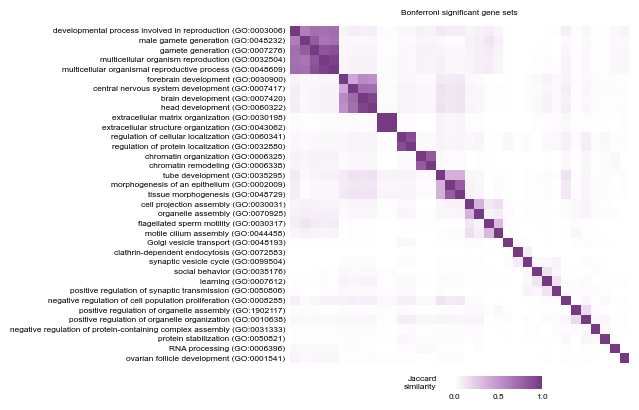

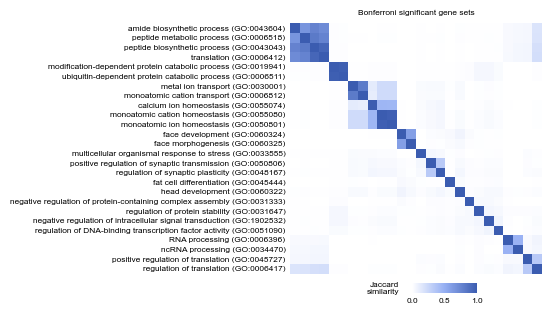

In [43]:
jaccard_matrices = {}
for disease in ['neuroblastoma', 'ewing']:
    
    gene_sets_to_show = sig_gene_sets[disease][0].index

    gs_list = []
    genes_list = []

    for gs, genes in gene_sets.items():
        if gs not in gene_sets_to_show:
            continue
        gs_list += [gs] * len(genes)
        genes_list += genes

    gs_gene_matrix = pd.DataFrame()
    gs_gene_matrix["gs"] = gs_list
    gs_gene_matrix["gene"] = genes_list
    gs_gene_matrix["value"] = 1

    gs_gene_matrix = (
        gs_gene_matrix.pivot(columns="gs", index="gene", values="value").fillna(0).T
    )

    data_values = gs_gene_matrix.values.astype(bool)

    j_dist = pdist(data_values, metric="jaccard")
    j_dist = 1 - squareform(j_dist)

    Z = linkage(j_dist, method="average")
    ordered_indices = leaves_list(Z)

    ordered_gs = gs_gene_matrix.index[ordered_indices]

    j_dist = j_dist[ordered_indices, :][:, ordered_indices]
    j_dist = pd.DataFrame(j_dist, index=ordered_gs, columns=ordered_gs);
    
    # make the color map
    custom_cmap = colors.LinearSegmentedColormap.from_list('custom', ['white', mc.palette[disease]['light2'], mc.palette[disease]['dark1']], N = 256)
    
    fig, ax = plt.subplots(1, figsize=np.array([0.125, 0.125]) * len(ordered_gs))
    sns.heatmap(j_dist, annot=False, cmap=custom_cmap, cbar=False)
    ax.set_yticks(np.array(range(len(ordered_gs))) + 0.5)
    ax.set_yticklabels(ordered_gs, fontsize = 6, va = 'center')
    ax.set_xticklabels([])
    ax.tick_params(axis = 'both', length = 0)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.text(s = 'Bonferroni significant gene sets', x = 0.5, y = 1.03, transform = ax.transAxes, ha = 'center', va = 'bottom')
    
    # add the colorbar
    cb = mpl.cm.ScalarMappable(cmap=custom_cmap)

    cbar_ax = fig.add_axes([0.5, 0.05, 0.2, 0.03])
    cbar = fig.colorbar(cb, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(size=0)
    cbar.outline.set_visible(False)
    cbar_ax.text(s = 'Jaccard\nsimilarity', x = -0.2, y = 0.5, ha = 'right', va = 'center')
    
    fig.savefig(f'data/updated-cwas/images/{disease}-gene-set-jaccard.pdf', bbox_inches = 'tight')

In [44]:
# category_order = []
# for disease in ["neuroblastoma", "ewing"]:
#     order_data = category_svs.query(
#         f'disease == "{disease}" & sv_category == "coding"'
#     ).copy()
#     order_data["disease_category"] = (
#         order_data["disease"] + " | " + order_data["category"]
#     )

#     order_data = order_data[(order_data["disease_category"].isin(sig_categories))]
#     order_data["value"] = 1

#     # get the actual SVs present in cases
#     svs_in_cases = list(
#         set(
#             ref_counts.query(
#                 f'sv_category == "coding" & disease == "{disease}" & cohort == "case" & dose > 0'
#             )["name"]
#         )
#     )
#     order_data = order_data[order_data["SV"].isin(svs_in_cases)]

#     order_data_pivoted = order_data.pivot(
#         columns="SV", index="disease_category", values="value"
#     ).fillna(0)

#     data_values = order_data_pivoted.values.astype(bool)

#     j_dist = pdist(data_values, metric="jaccard")
#     j_dist = 1 - squareform(j_dist)

#     Z = linkage(j_dist, method="average")
#     ordered_indices = leaves_list(Z)

#     ordered_categories = order_data_pivoted.index[ordered_indices]
#     print(ordered_categories)

#     category_order += list(ordered_categories)

We drop some gene sets here:

In [45]:
# dropped_gs = [
#     "female pregnancy (GO:0007565)",
#     "epithelial cilium movement involved in extracellular fluid movement (GO:0003351)",
#     "extracellular transport (GO:0006858)",
#     "motile cilium assembly (GO:0044458)",
#     "cell projection assembly (GO:0030031)",
#     "cilium assembly (GO:0060271)",
#     "negative regulation of protein-containing complex assembly (GO:0031333)",
#     "female gamete generation (GO:0007292)",
#     "ovarian follicle development (GO:0001541)",
#     "regulation of cell-substrate adhesion (GO:0010810)",
#     'regulation of protein depolymerization (GO:1901879)',
#     'developmental growth (GO:0048589)'
# ]

In [46]:
category_order = [
    "neuroblastoma | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding",
    "neuroblastoma | ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding",
    "ewing | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
]

Drop some gene sets and some categories (I dislike the unconstrained categories)

In [47]:
# ordered_gs = [gs for gs in ordered_gs if gs not in dropped_gs]
# category_order = [cat for cat in category_order if 'unconstrained' not in cat]

gs_names = ['Forebrain', 'CNS', 'Brain', 'Head', 'Transmission', 'Plasticity', 'Metal ions', 'Cations', 'Calcium', 'Amide', 'Peptide']

ordered_gs = ['forebrain development (GO:0030900)',
 'central nervous system development (GO:0007417)',
 'brain development (GO:0007420)',
 'head development (GO:0060322)',
             'positive regulation of synaptic transmission (GO:0050806)',
 'regulation of synaptic plasticity (GO:0048167)',
             'metal ion transport (GO:0030001)',
 'monoatomic cation transport (GO:0006812)',
             'calcium ion homeostasis (GO:0055074)',
             'amide biosynthetic process (GO:0043604)',
             'peptide biosynthetic process (GO:0043043)']

gs_to_name = dict(zip(ordered_gs, gs_names))

In [48]:
traits = ['expressed_in_',
 'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP',
          'unconstrained',
 'DEL']
trait_names = ['Gene expressed in\ntissue of origin', 'LoF SV', 'Unconstrained', 'Deletion']
trait_matrix = []
for t in traits:
    row = []
    for c in category_order:
        value = 1 if t in c else 0
        row.append(value)
        
    trait_matrix.append(row)
    
trait_matrix = pd.DataFrame(trait_matrix, columns = category_order, index = traits)

In [49]:
trait_matrix

,neuroblastoma | ANY.SINGLETON.ANY.ANY.ANY.protein_coding,neuroblastoma | DEL.SINGLETON.ANY.ANY.ANY.protein_coding,neuroblastoma | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,neuroblastoma | ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding,neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,neuroblastoma | ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding,ewing | ANY.SINGLETON.ANY.ANY.ANY.protein_coding,ewing | DEL.SINGLETON.ANY.ANY.ANY.protein_coding,ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding
expressed_in_,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1
PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP,0,0,1,1,0,1,0,1,0,0,1,1,1,0,1,0
unconstrained,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
DEL,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0


Alright, let's make this sucker.

In [50]:
groupings = {'neurodevelopment': ['forebrain development (GO:0030900)',
                                  'central nervous system development (GO:0007417)',
                                  'brain development (GO:0007420)',
                                  'head development (GO:0060322)'],
             'synapse': ['positive regulation of synaptic transmission (GO:0050806)',
                                 'regulation of synaptic plasticity (GO:0048167)'],
             'ion biology': ['metal ion transport (GO:0030001)',
                             'monoatomic cation transport (GO:0006812)',
                             'calcium ion homeostasis (GO:0055074)'],
             'biosynthesis': ['amide biosynthetic process (GO:0043604)',
                              'peptide biosynthetic process (GO:0043043)']}

In [51]:
from matplotlib import colors

In [52]:
cmaps = {dz: colors.LinearSegmentedColormap.from_list('custom', ['white', mc.palette[dz]['light2'], mc.palette[dz]['dark1']], N = 256) for dz in ['neuroblastoma', 'ewing']}

In [53]:
sig_gene_sets_total = sorted(set(sig_gene_sets['neuroblastoma'][0].index.tolist() + sig_gene_sets['ewing'][0].index.tolist()))

In [54]:
# we need to get data for all the significant gene sets, unfortunately
total_heatmap_data = coding_results.copy()
total_heatmap_data["disease_category"] = (
    total_heatmap_data["disease"] + " | " + total_heatmap_data["category"]
)
total_heatmap_data = total_heatmap_data[total_heatmap_data["disease_category"].isin(category_order)]

total_heatmap_values = total_heatmap_data[total_heatmap_data["gs"].isin(sig_gene_sets_total)]

total_heatmap_p = total_heatmap_values.pivot(
    index="disease_category", columns="gs", values="y_baseline"
)

total_heatmap_values = total_heatmap_values.pivot(
    index="disease_category", columns="gs", values="x_baseline"
)

total_heatmap_values = total_heatmap_values.loc[category_order].T
total_heatmap_p = total_heatmap_p.loc[category_order].T

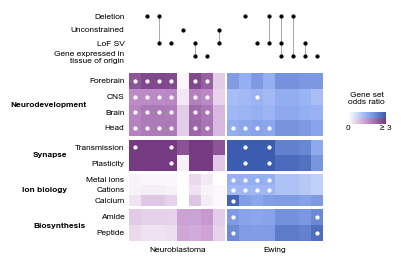

In [56]:
fig = plt.figure(figsize=(2.5, 3), tight_layout=False)
gs = fig.add_gridspec(6, 2, hspace = 0.1, wspace = 0.02, width_ratios = [8, 8], 
                       height_ratios = [1.7, 0.1, 2, 1, 1, 1])

# plot the category "labels"
cat_axes = []
for k, disease in enumerate(['neuroblastoma', 'ewing']):
    ax = fig.add_subplot(gs[0, k])
    cat_axes.append(ax)
    
    disease_cols = [c for c in trait_matrix.columns if disease in c]
    subtrait_matrix = trait_matrix.loc[:, disease_cols]

    for j in range(subtrait_matrix.shape[1]):

        connections = []

        for i in range(subtrait_matrix.shape[0]):
            val = subtrait_matrix.iloc[i, j]
            if val == 1:
                ax.scatter([j + 0.5], [i + 0.5], color = 'black', s = 5)
                connections.append(i + 0.5)

        # plot connecting lines
        if connections:
            ax.plot([j + 0.5] * len(connections), connections, color = 'darkgrey', zorder = 0, linewidth = 0.75)
            
    ax.set_ylim([0, 4])
    ax.set_xlim([0, subtrait_matrix.shape[1]])
    
    if k == 0:
        ax.set_yticks(np.arange(0, len(traits)) + 0.5)
        ax.set_yticklabels(trait_names, fontsize = 6)
        aesthetics.strip_axis(ax, y = 'label')
    else:
        aesthetics.strip_axis(ax)

# plot by each group - 3 x 2
ylabel_offsets = {'neurodevelopment': -0.45, 'synapse': -0.65, 'ion biology': -0.65, 'biosynthesis': -0.45}
for i, (g, g_gene_sets) in enumerate(groupings.items()):
    row = i + 2
    
    for j, disease in enumerate(['neuroblastoma', 'ewing']):
        sharex = cat_axes[j]
        ax = fig.add_subplot(gs[row, j], sharex = sharex)
        
        # get the data
        disease_cols = [c for c in category_order if disease in c]
        subheatmap = total_heatmap_values.loc[g_gene_sets, disease_cols]
        
        ax.set_xlim([0, len(disease_cols)])
        
        sns.heatmap(
            subheatmap,
            ax=ax,
            cmap=cmaps[disease],
            vmin=0,
            vmax=3,
            cbar = None
        )
        
        ax.set_yticks(np.arange(0, len(g_gene_sets)) + 0.5)
        
        for row_i, cat in enumerate(disease_cols):
            for row_j, sub_gs in enumerate(g_gene_sets):

                y_baseline = total_heatmap_p.loc[sub_gs, cat]
                if y_baseline > -np.log10(0.05 / num_effective_gene_sets):
                    ax.scatter([row_i + 0.5], [row_j + 0.5], s = 5, color = 'white')
                    
        if j != 0:
            aesthetics.strip_axis(ax)
        
        else:
            names = [gs_to_name[sub_gs] for sub_gs in g_gene_sets]
            ax.set_yticklabels(names, rotation = 0, fontsize = 6)
            ax.tick_params(axis = 'both', length = 0)
            ax.set_xticks([])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.text(s = g.capitalize(), x = ylabel_offsets[g], y = 0.5, ha = 'right', 
                    va = 'center', transform = ax.transAxes, weight = 'bold')
            
        if i == 3:
            ax.text(s = disease.capitalize(), x = 0.5, y = -0.2, transform = ax.transAxes, va = 'top', ha = 'center')
    
norm = mpl.colors.Normalize(vmin=0, vmax=3)
nbl_cb = mpl.cm.ScalarMappable(norm=norm, cmap=cmaps['neuroblastoma'])
ews_cb = mpl.cm.ScalarMappable(norm=norm, cmap=cmaps['ewing'])

for i, cb in enumerate([nbl_cb, ews_cb]):

    cbar_ax = fig.add_axes([1, 0.5 + 0.02 * i, 0.15, 0.02])
    cbar = fig.colorbar(cb, cax=cbar_ax, orientation='horizontal')

    cbar.ax.tick_params(size=0)
    
    if i == 0:
        cbar.ax.set_xticklabels([])
    else:
        cbar.ax.set_xticks([0, 3])
        cbar.ax.set_xticklabels(['0', '≥ 3'])
        cbar.ax.tick_params(axis='x', pad=5)
        cbar.ax.set_title('Gene set\nodds ratio')

    cbar.outline.set_visible(False)

fig.savefig('data/updated-cwas/images/gse-heatmap.pdf', bbox_inches = 'tight')

# Plan for figure 4:

A: NBL and EWS specific category example  
B: Gene set heatmap  
C: Odds ratio plot +/- within category stuff > SV burden  
D: Expression example  
E: Expression in category compared to all others (coding + noncoding)  

In [62]:
noncoding_results = gse_results.query('disease == "neuroblastoma" & sv_category == "noncoding"')
noncoding_results = noncoding_results[noncoding_results['category'].str.contains('SINGLETON')]

In [63]:
# noncoding_results.query('p_cases_fisher < 0.05 & category == "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding"').sort_values(by = 'p_cases_fisher').head(100)

[Text(0, 0, '1'), Text(2, 0, '4'), Text(4, 0, '16'), Text(6, 0, '64')]

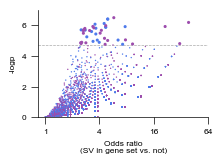

In [61]:
test_cat = "ANY.SINGLETON.ANY.ANY.ANY.protein_coding"

palette = {'neuroblastoma': mc.palette['neuroblastoma']["main"],
           'ewing': mc.palette['ewing']["main"]}

fig, ax = plt.subplots(1, figsize=(2.2, 1.4))

# data = combined_gse_results.query('odds_ratio_cases_fisher > odds_ratio_controls_fisher').copy()
coding_results = gse_results.query('sv_category == "coding" & odds_ratio_cases > 1').copy()
coding_results["x_baseline"] = np.log2(coding_results["odds_ratio_cases"])
coding_results["y_baseline"] = -np.log10(coding_results["p_cases"])

data = coding_results.query(f'category == "{test_cat}"').copy()

nlp_bonf = -np.log10(p_bonf_cutoff)
data['size'] = np.where(data['y_baseline'] > nlp_bonf, 5, 1)
data['c'] = data['disease'].replace(palette)

# plot the significant ones first
sig = data.query(f'y_baseline > {nlp_bonf}')
points = ax.scatter(x = sig['x_baseline'], y = sig['y_baseline'], s = sig['size'], ec = None, c = sig['c'])

# labeled_sig = sig[sig['gs'].isin(labeled_gs)]
# points = ax.scatter(x = labeled_sig['x_baseline'], y = labeled_sig['y_baseline'], s = 10, ec = None, c = 'black')

nonsig = data.query(f'y_baseline < {nlp_bonf}').sample(frac = 1)
for chunk in np.array_split(nonsig, 200):
    zorder = np.random.uniform()
    points = ax.scatter(x = chunk['x_baseline'], y = chunk['y_baseline'], s = chunk['size'], ec = None, c = chunk['c'])

sns.despine(ax=ax)
ax.set_xlim([None, 6])
ax.set_ylim([0, 7])
ax.axhline(
    y=nlp_bonf,
    linestyle="dashed",
    color="darkgrey",
    zorder=-1,
    linewidth = 0.5
)
ax.set_ylabel("-logp")
ax.set_xlabel("Odds ratio\n(SV in gene set vs. not)", fontsize = 6)

ax.set_xticks([0, 2, 4, 6])
ax.set_xticklabels([1, 4, 16, 64])

# ax.legend(bbox_to_anchor = (1, 0.5))

# fig.savefig('images/test-gene-sets-any.pdf')

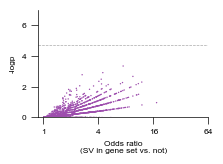

In [64]:
test_cat = "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding"

palette = {'neuroblastoma': mc.palette['neuroblastoma']["main"],
           'ewing': mc.palette['ewing']["main"]}

fig, ax = plt.subplots(1, figsize=(2.2, 1.4))

coding_results = gse_results.query('sv_category == "noncoding" & odds_ratio_cases > 1').copy()
coding_results["x_baseline"] = np.log2(coding_results["odds_ratio_cases"])
coding_results["y_baseline"] = -np.log10(coding_results["p_cases"])

data = coding_results.query(f'category == "{test_cat}"').copy()

nlp_bonf = -np.log10(p_bonf_cutoff)
data['size'] = np.where(data['y_baseline'] > nlp_bonf, 5, 1)
data['c'] = data['disease'].replace(palette)

# plot the significant ones first
sig = data.query(f'y_baseline > {nlp_bonf}')
points = ax.scatter(x = sig['x_baseline'], y = sig['y_baseline'], s = sig['size'], ec = None, c = sig['c'])

nonsig = data.query(f'y_baseline < {nlp_bonf}').sample(frac = 1)
for chunk in np.array_split(nonsig, 200):
    zorder = np.random.uniform()
    points = ax.scatter(x = chunk['x_baseline'], y = chunk['y_baseline'], s = chunk['size'], ec = None, c = chunk['c'])

sns.despine(ax=ax)
ax.set_xlim([None, 6])
ax.set_ylim([0, 7])
ax.axhline(
    y=nlp_bonf,
    linestyle="dashed",
    color="darkgrey",
    zorder=-1,
    linewidth = 0.5
)
ax.set_ylabel("-logp")
ax.set_xlabel("Odds ratio\n(SV in gene set vs. not)", fontsize = 6)

ax.set_xticks([0, 2, 4, 6])
ax.set_xticklabels([1, 4, 16, 64])

fig.savefig('data/updated-cwas/images/neuroblastoma-tad-boundary-GSEA.pdf', bbox_inches = 'tight')